In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from os.path import join
from os import environ

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_new_architecture_test3')

In [3]:
home=environ['HOME']
folder1='GRIMech_CH4_models_RS3_15_trajectories'
folder2='Datasets'

cantera_species=pd.read_csv(join(home, folder1,folder2,'State_space_cte_pressure_T1418_st-quarter_phi_14.csv'))
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(join(home,folder1,folder2,'Reaction_rates_cte_pressure_T1418_st-quarter_phi_14.csv'))
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv(join(home,folder1,folder2,'maximum_values_T1418.csv'))
maximum_values=pd.DataFrame(maximum_values)

In [4]:
def hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:]
    print(np.shape(cantera_species_fractions))
    
    cantera_species_fractions=cantera_species_fractions.loc[:,(cantera_species!=0).any(axis=0)]
    cantera_species_fractions=cantera_species_fractions.loc[:, (cantera_species != cantera_species.iloc[0]).any()]
    print(np.shape(cantera_species_fractions))
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    print(n_columns_mass_fraction)
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    print(np.shape(cantera_sources))
    n_columns_source=np.shape(cantera_sources)[1]
    print(n_columns_source)
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[:,1:]
    maximum_values=pd.concat([maximum_values.iloc[:,0:2],maximum_values.iloc[:,3:]],axis=1)
    #print(maximum_values)
    
    maximum_values=maximum_values.to_numpy()
    #print(np.shape(maximum_values))
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[0,j])
        #print(maximum_values[0,j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values)

(120000, 49)
(120000, 30)
30
(120000, 30)
30


In [6]:
dataset

,t[s],T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,...,CH3OHwshift,C2Hwshift,C2H2wshift,C2H3wshift,C2H4wshift,C2H5wshift,C2H6wshift,HCCOwshift,CH2COwshift,HCCOHwshift
0,0.000008,0.405009,5.085657e-11,2.057781e-09,4.281242e-11,0.759665,2.403522e-11,4.482343e-13,0.000001,2.026852e-09,...,4.320150e-09,1.369980e-27,1.129104e-16,2.188015e-17,3.599823e-08,1.644153e-05,-1.140905e-03,8.198113e-27,5.152100e-27,3.324747e-28
1,0.000017,0.405009,1.961998e-10,3.892629e-09,1.596654e-10,0.759665,9.174804e-11,3.336850e-12,0.000003,8.103681e-09,...,9.419998e-09,7.013056e-27,2.572510e-16,6.748007e-17,5.500175e-08,1.701478e-05,-1.141276e-03,5.762348e-26,3.682331e-26,2.414583e-27
2,0.000025,0.405009,4.258395e-10,5.529585e-09,3.349024e-10,0.759665,1.967607e-10,1.080154e-11,0.000004,1.822743e-08,...,1.623427e-08,2.228952e-26,4.629942e-16,1.494429e-16,7.464455e-08,1.756703e-05,-1.141643e-03,2.261326e-25,1.498386e-25,9.769750e-27
3,0.000033,0.405009,7.306494e-10,6.991100e-09,5.553688e-10,0.759665,3.332013e-10,2.467216e-11,0.000006,3.239452e-08,...,2.460138e-08,5.389726e-26,7.321506e-16,2.754543e-16,9.490228e-08,1.809736e-05,-1.142004e-03,6.437192e-25,4.455876e-25,2.864085e-26
4,0.000042,0.405009,1.102591e-09,8.296990e-09,8.102694e-10,0.759665,4.958003e-10,4.647059e-11,0.000007,5.060136e-08,...,3.437549e-08,1.093832e-25,1.066654e-15,4.517514e-16,1.157497e-07,1.860519e-05,-1.142358e-03,1.495529e-24,1.084093e-24,6.846409e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.999958,0.914734,2.391744e+00,1.091865e+00,9.246462e-02,0.003831,3.209633e-01,9.426628e-01,0.002191,4.751707e-03,...,1.140924e-18,4.537321e-20,3.519080e-20,7.782102e-23,6.982633e-24,6.736248e-26,1.414971e-27,4.041289e-19,2.824699e-19,1.674359e-20
119995,0.999967,0.914734,2.391744e+00,1.091865e+00,9.246462e-02,0.003831,3.209633e-01,9.426628e-01,0.002191,4.751707e-03,...,1.142450e-18,4.534696e-20,3.517195e-20,7.784662e-23,6.976552e-24,6.727584e-26,1.407835e-27,4.033920e-19,2.823220e-19,1.667671e-20
119996,0.999975,0.914734,2.391744e+00,1.091865e+00,9.246462e-02,0.003831,3.209633e-01,9.426628e-01,0.002191,4.751707e-03,...,1.137803e-18,4.485755e-20,3.517447e-20,7.768992e-23,6.977426e-24,6.724682e-26,1.410473e-27,4.038411e-19,2.823480e-19,1.665575e-20
119997,0.999983,0.914734,2.391744e+00,1.091865e+00,9.246462e-02,0.003831,3.209633e-01,9.426628e-01,0.002191,4.751707e-03,...,1.136742e-18,4.552700e-20,3.511874e-20,7.768683e-23,6.971130e-24,6.725644e-26,1.405985e-27,4.031327e-19,2.822974e-19,1.670731e-20


In [7]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [8]:
interest_vector=['T[K]','CH3', 'CH4', 'H2O','O2','H2','OH','HO2','H2O2']

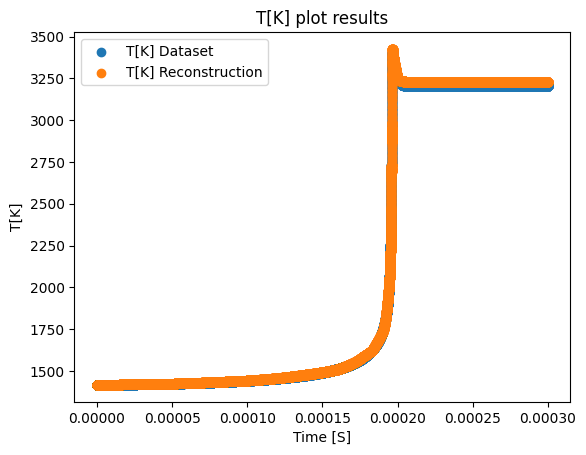

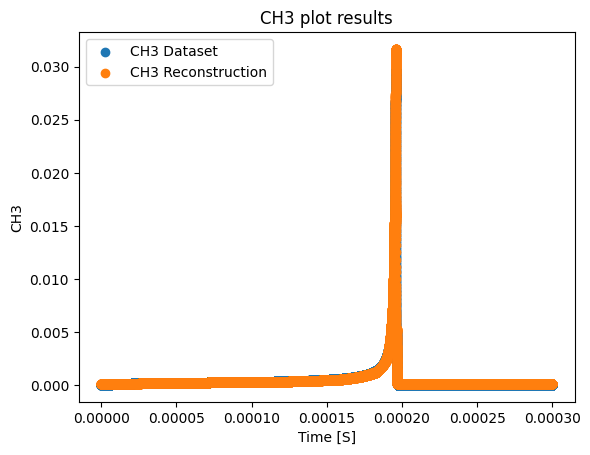

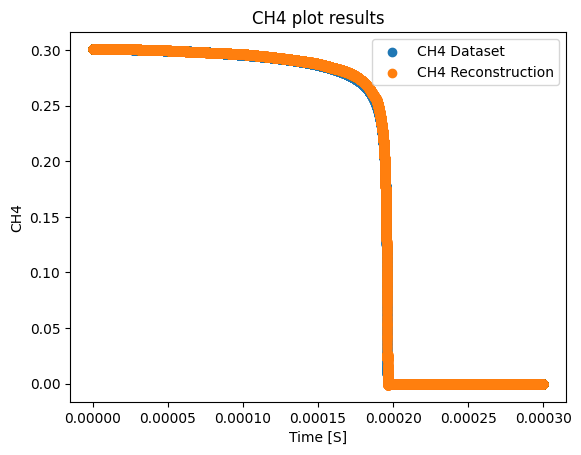

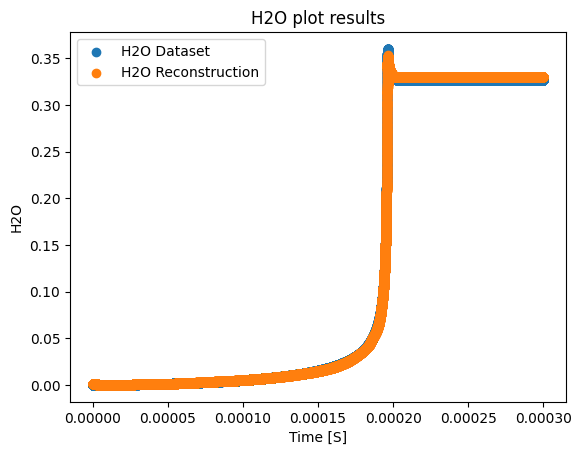

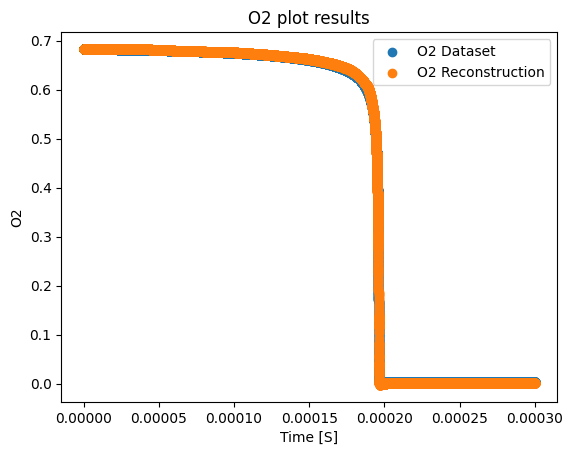

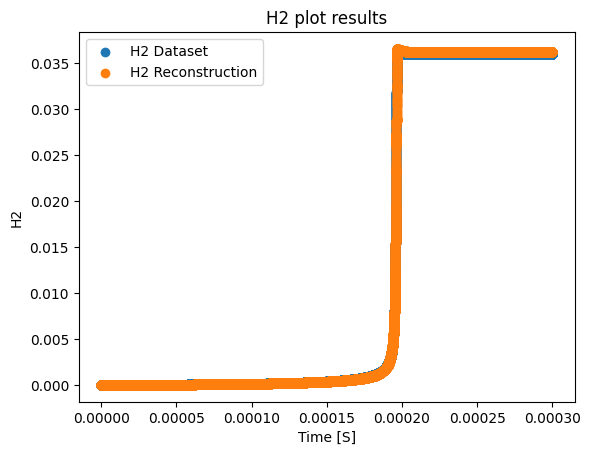

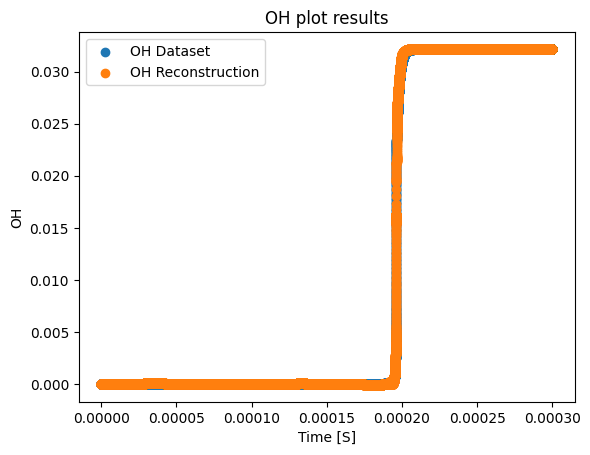

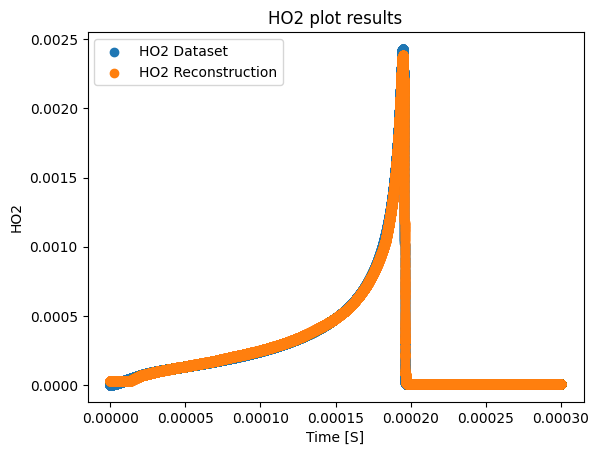

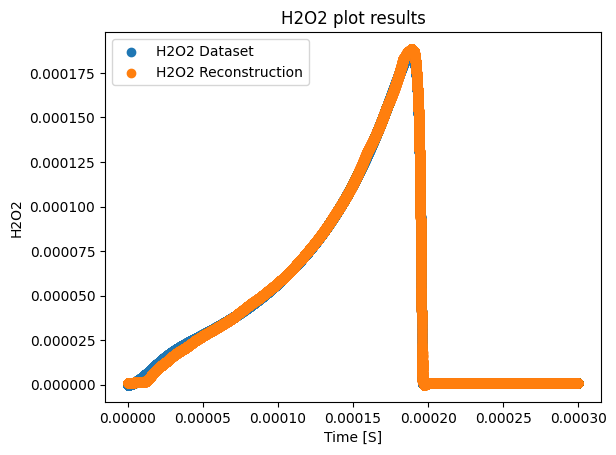

In [9]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]
    
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    #print(columns[original_index])
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 
    #print(columns[results_index])
    #print(results_index-1)
    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Dataset'
    output_label=interest_vector[k]+' Reconstruction'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    #original=original*transformation_values[1,original_index]
    #original=original+transformation_values[0,original_index]
    #original=np.exp(original)-1
    original=original*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    #output=output*transformation_values[1,results_index]
    #output=output+transformation_values[0,results_index]
    #output=np.exp(output)-1
    output=output*maximum_values.iloc[0,transformation_index]
    
    plt.figure(k)
    plt.scatter(time_plot,original, label=input_label)
    plt.scatter(time_plot,output, label=output_label)
    plt.title(interest_vector[k]+' plot results')
    plt.xlabel('Time [S]')
    plt.ylabel(interest_vector[k])
    plt.legend()

In [10]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

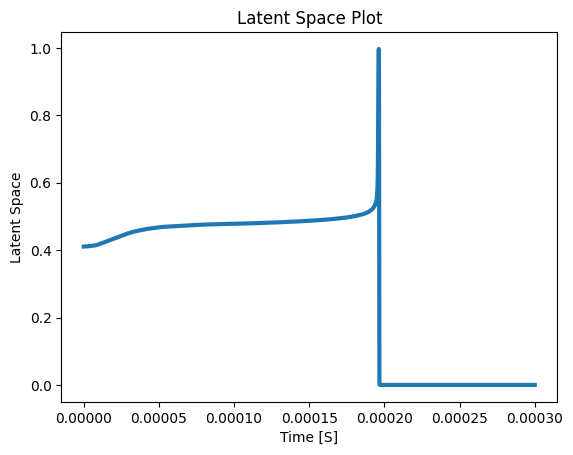

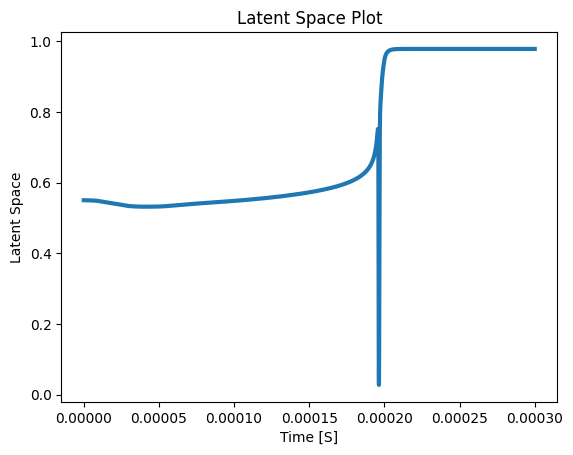

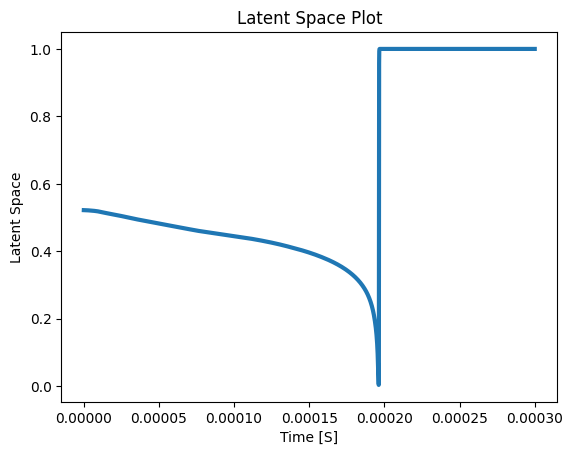

In [11]:
reduced_size=3

if reduced_size==1:
    plt.figure()
    plt.plot(time_plot,latent_space,linewidth=3)
    plt.title('Latent Space Plot')
    plt.xlabel('Time [S]')
    plt.ylabel('Latent Space')
else: 
    for i in range(reduced_size):
            plt.figure(i)
            plt.plot(time_plot,latent_space[:,i],linewidth=3)
            plt.title('Latent Space Plot')
            plt.xlabel('Time [S]')
            plt.ylabel('Latent Space')

In [12]:
corr_dataset=dataset.iloc[:,1:2+n_columns_mass_fraction+n_columns_source]
corr_columns=corr_dataset.columns.to_list()
corr_dataset

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.405009,5.085657e-11,2.057781e-09,4.281242e-11,0.759665,2.403522e-11,4.482343e-13,0.000001,2.026852e-09,9.699828e-35,...,1.114500e-09,8.262556e-29,2.787845e-17,3.222285e-18,1.765721e-08,1.584863e-05,-1.140529e-03,2.854087e-28,1.940490e-28,1.121092e-29
1,0.405009,1.961998e-10,3.892629e-09,1.596654e-10,0.759665,9.174804e-11,3.336850e-12,0.000003,8.103681e-09,4.595281e-33,...,4.320150e-09,1.369980e-27,1.129104e-16,2.188015e-17,3.599823e-08,1.644153e-05,-1.140905e-03,8.198113e-27,5.152100e-27,3.324747e-28
2,0.405009,4.258395e-10,5.529585e-09,3.349024e-10,0.759665,1.967607e-10,1.080154e-11,0.000004,1.822743e-08,3.874927e-32,...,9.419998e-09,7.013056e-27,2.572510e-16,6.748007e-17,5.500175e-08,1.701478e-05,-1.141276e-03,5.762348e-26,3.682331e-26,2.414583e-27
3,0.405009,7.306494e-10,6.991100e-09,5.553688e-10,0.759665,3.332013e-10,2.467216e-11,0.000006,3.239452e-08,1.599626e-31,...,1.623427e-08,2.228952e-26,4.629942e-16,1.494429e-16,7.464455e-08,1.756703e-05,-1.141643e-03,2.261326e-25,1.498386e-25,9.769750e-27
4,0.405009,1.102591e-09,8.296990e-09,8.102694e-10,0.759665,4.958003e-10,4.647059e-11,0.000007,5.060136e-08,4.552158e-31,...,2.460138e-08,5.389726e-26,7.321506e-16,2.754543e-16,9.490228e-08,1.809736e-05,-1.142004e-03,6.437192e-25,4.455876e-25,2.864085e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.914734,2.391744e+00,1.091865e+00,9.246462e-02,0.003831,3.209633e-01,9.426628e-01,0.002191,4.751707e-03,2.867852e-06,...,1.143064e-18,4.545997e-20,3.520597e-20,7.788452e-23,6.994472e-24,6.745264e-26,1.409713e-27,4.041749e-19,2.831674e-19,1.676453e-20
119995,0.914734,2.391744e+00,1.091865e+00,9.246462e-02,0.003831,3.209633e-01,9.426628e-01,0.002191,4.751707e-03,2.867852e-06,...,1.140924e-18,4.537321e-20,3.519080e-20,7.782102e-23,6.982633e-24,6.736248e-26,1.414971e-27,4.041289e-19,2.824699e-19,1.674359e-20
119996,0.914734,2.391744e+00,1.091865e+00,9.246462e-02,0.003831,3.209633e-01,9.426628e-01,0.002191,4.751707e-03,2.867852e-06,...,1.142450e-18,4.534696e-20,3.517195e-20,7.784662e-23,6.976552e-24,6.727584e-26,1.407835e-27,4.033920e-19,2.823220e-19,1.667671e-20
119997,0.914734,2.391744e+00,1.091865e+00,9.246462e-02,0.003831,3.209633e-01,9.426628e-01,0.002191,4.751707e-03,2.867852e-06,...,1.137803e-18,4.485755e-20,3.517447e-20,7.768992e-23,6.977426e-24,6.724682e-26,1.410473e-27,4.038411e-19,2.823480e-19,1.665575e-20


In [13]:
iterations=np.shape(corr_dataset)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes=np.zeros(iterations) #rows, columns
    corr_indexes=np.array([corr_indexes])
    
    for j in range(iterations):
        corr_indexes[:,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space)
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)
else: 
    
    corr_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes[k,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space[:,k])
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)

In [14]:
corr_indexes

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.044992,0.046100,-0.095551,-0.095551,-0.046789,-0.095551,0.049917,0.814802,0.795642,0.055808,...,0.792056,0.827768,0.827412,0.825287,0.812026,0.698905,0.281513,0.826896,0.826236,0.830285
1,0.735966,0.734855,0.862574,0.862574,-0.734162,0.862574,0.731023,-0.046702,-0.046802,0.725110,...,-0.068120,-0.059039,-0.058706,-0.057045,-0.061296,-0.002136,-0.016311,-0.058188,-0.057525,-0.061550
2,0.022446,0.021299,0.032032,0.032032,-0.020585,0.032032,0.017346,-0.912610,-0.892852,0.011246,...,-0.889161,-0.925198,-0.924815,-0.923582,-0.909830,-0.789008,-0.356568,-0.925260,-0.924573,-0.924100


C2H5     0.974306
C2H4     0.972572
CH3      0.971183
CH3O     0.971167
CH3OH    0.970209
Name: 0, dtype: float64
H      0.862574
O      0.862574
CO2    0.862574
OH     0.862574
HCO    0.776556
Name: 1, dtype: float64
CH4w    0.935714
O2w     0.926184
H       0.032032
O       0.032032
CO2     0.032032
Name: 2, dtype: float64


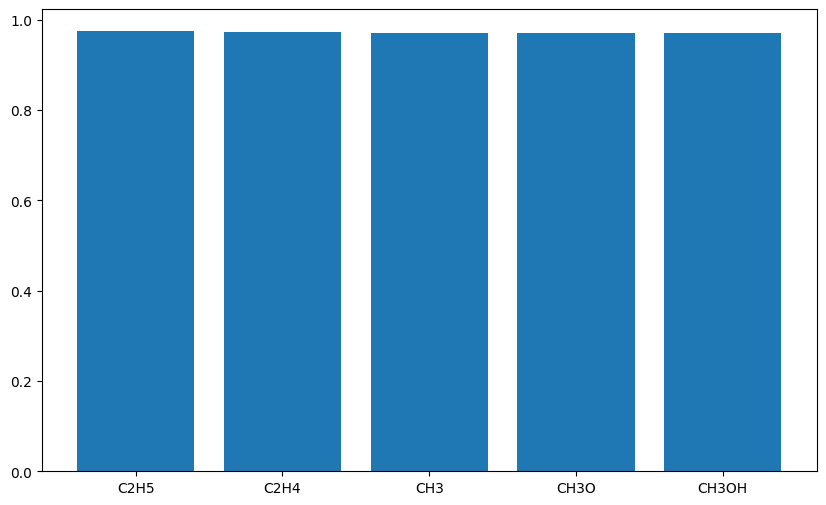

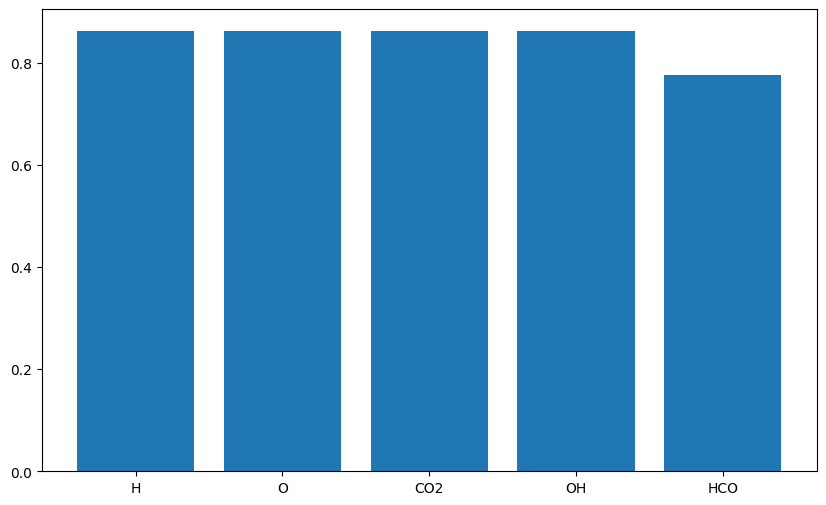

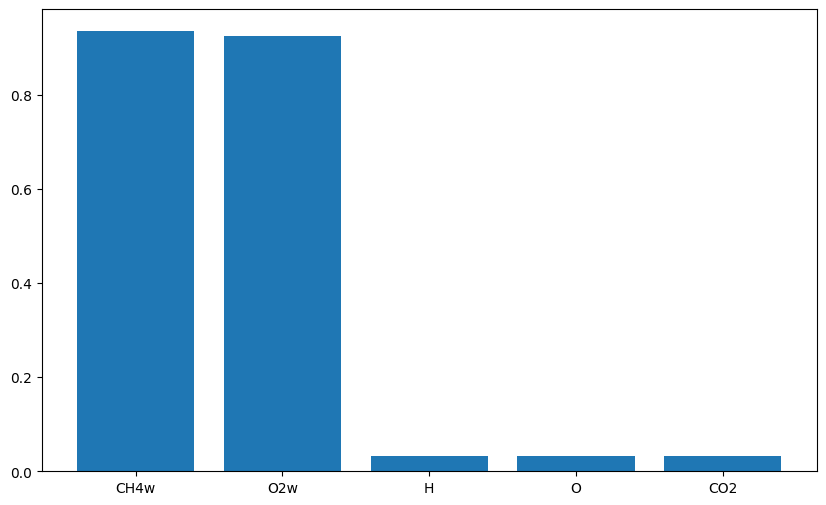

In [15]:
for m in range(reduced_size):
    
    indexes=corr_indexes.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [16]:
if reduced_size==1:
    spearman_indexes=np.zeros(iterations) #rows, columns
    spearman_indexes=np.array([spearman_indexes])
    
    for j in range(iterations):
        spearman_indexes[:,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space)
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)
else: 
    
    spearman_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            spearman_indexes[k,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space[:,k])
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)

In [17]:
spearman_indexes

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,-0.366758,-0.369783,-0.429786,-0.429786,0.369438,-0.429786,-0.364343,0.924396,0.913138,-0.350023,...,0.877117,0.928627,0.926655,0.924465,0.905200,0.870153,0.332527,0.927098,0.925976,0.929214
1,0.889329,0.894679,0.949779,0.949779,-0.894209,0.949779,0.886657,-0.386643,-0.376563,0.883224,...,-0.414138,-0.401309,-0.400844,-0.399350,-0.405342,-0.372016,-0.210279,-0.401008,-0.400052,-0.401633
2,0.401751,0.403775,0.409045,0.409045,-0.403424,0.409045,0.399312,-0.966063,-0.955728,0.384785,...,-0.919271,-0.970828,-0.969102,-0.967321,-0.947769,-0.910535,-0.364637,-0.970051,-0.968878,-0.969374


C2H5     0.994373
C2H4     0.993070
CH3OH    0.992309
CH3O     0.992152
CH3      0.991545
Name: 0, dtype: float64
H      0.949779
O      0.949779
CO2    0.949779
OH     0.949779
HCO    0.896532
Name: 1, dtype: float64
CH4w    0.976322
O2w     0.970986
H       0.409045
O       0.409045
CO2     0.409045
Name: 2, dtype: float64


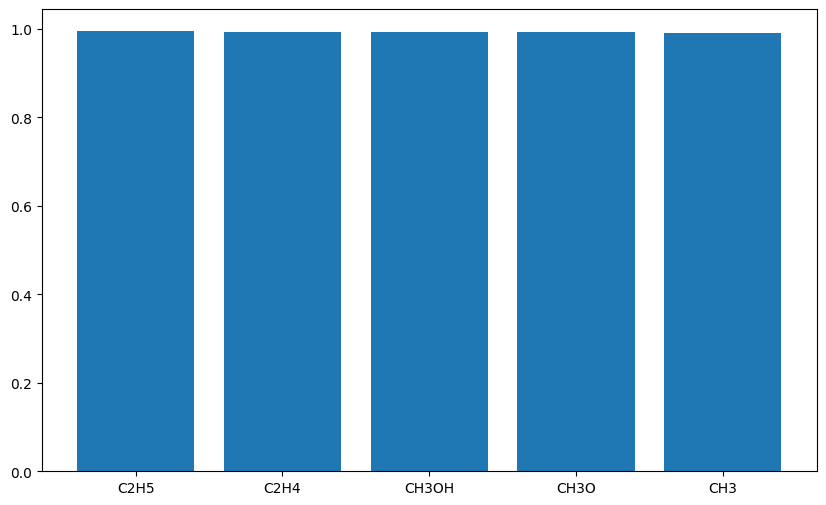

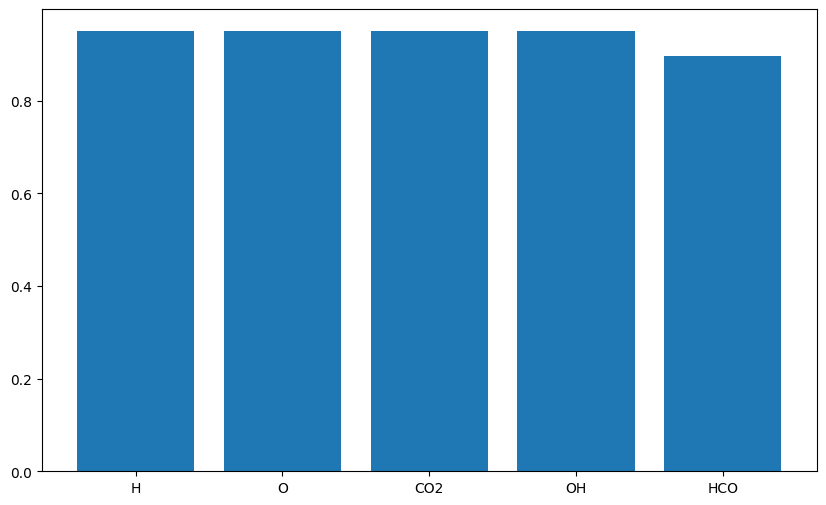

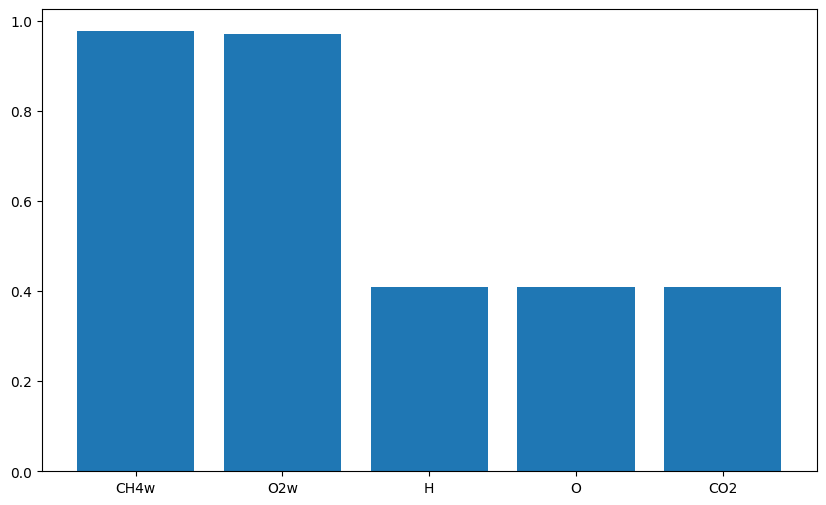

In [18]:
for m in range(reduced_size):
    
    indexes=spearman_indexes.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [19]:
n_samples=np.shape(latent_space)[0]

corr_dataset_=corr_dataset.iloc[1:,:]

latent_space_=latent_space[0:n_samples-1,:]

In [20]:
print(np.shape(corr_dataset_))
print(np.shape(latent_space_))

(119998, 61)
(119998, 3)


In [21]:
iterations=np.shape(corr_dataset_)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes_=np.zeros(iterations) #rows, columns
    corr_indexes_=np.array([corr_indexes_])
    
    for j in range(iterations):
        corr_indexes_[:,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_)
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)
else: 
    
    corr_indexes_=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes_[k,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_[:,k])
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)

In [22]:
corr_indexes_

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.045019,0.046125,-0.095543,-0.095543,-0.046815,-0.095543,0.049943,0.814782,0.795621,0.055834,...,0.792024,0.827739,0.827379,0.825254,0.811994,0.698870,0.281500,0.826866,0.826205,0.830255
1,0.735954,0.734845,0.862574,0.862574,-0.734152,0.862574,0.731013,-0.046679,-0.046813,0.725100,...,-0.068122,-0.058999,-0.058663,-0.057045,-0.061299,-0.002115,-0.016337,-0.058148,-0.057484,-0.061509
2,0.022421,0.021276,0.032021,0.032021,-0.020562,0.032021,0.017323,-0.912593,-0.892832,0.011223,...,-0.889128,-0.925167,-0.924782,-0.923549,-0.909797,-0.788973,-0.356553,-0.925229,-0.924541,-0.924069


C2H5     0.974319
C2H4     0.972561
CH3      0.971212
CH3O     0.971204
CH3OH    0.970213
Name: 0, dtype: float64
H      0.862574
O      0.862574
CO2    0.862574
OH     0.862574
HCO    0.776556
Name: 1, dtype: float64
CH4w    0.935739
O2w     0.926197
H       0.032021
O       0.032021
CO2     0.032021
Name: 2, dtype: float64


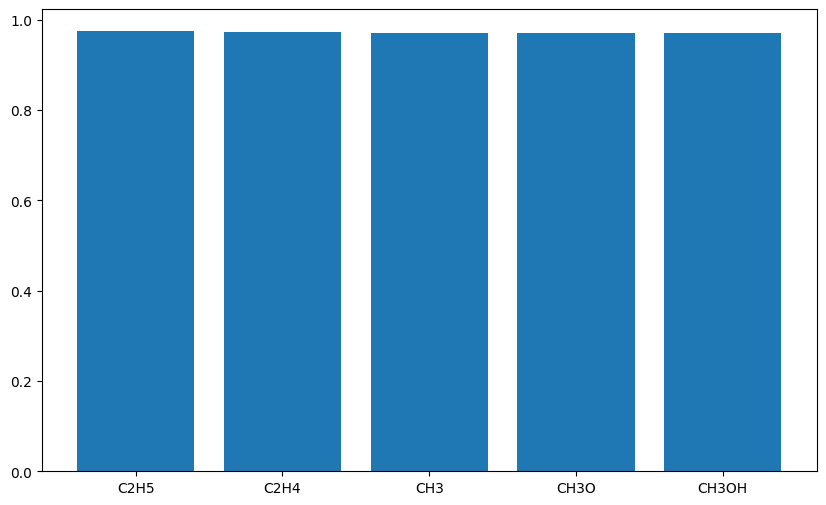

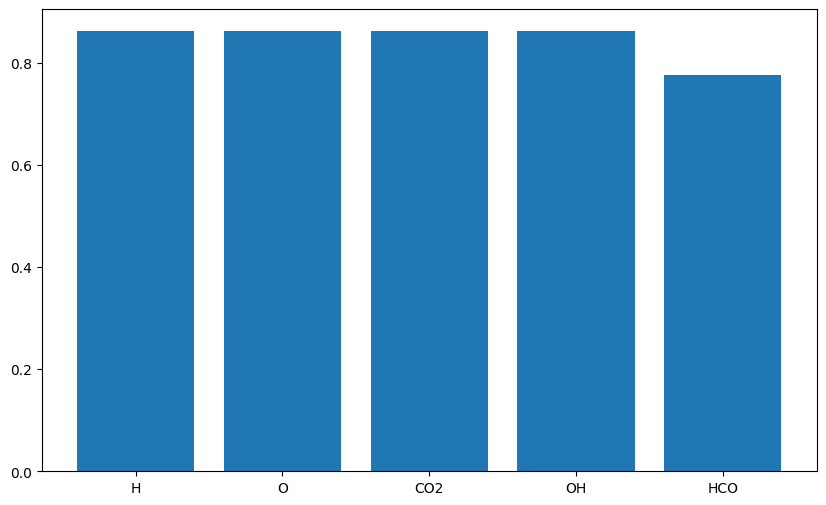

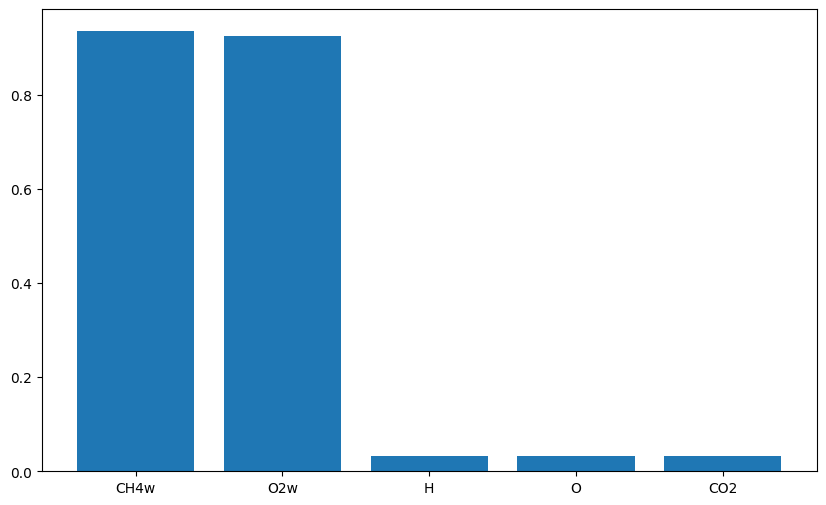

In [23]:
for m in range(reduced_size):
    
    indexes=corr_indexes_.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)